In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
import umap

## 2D regression dataset

In [4]:
num_points = 50
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

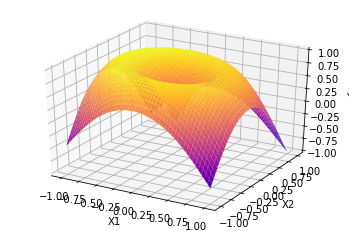

In [46]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [47]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
#         invA = A.t()
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [48]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Distance Embedding of the data

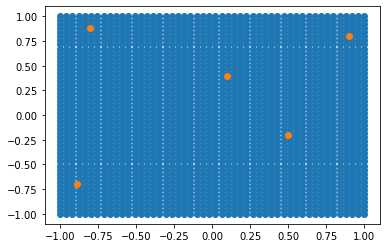

In [49]:
centers = torch.Tensor([[0.9, 0.8],
                        [-0.8, 0.88],
                        [-0.89, -0.7],
                        [0.1, 0.4],
                        [0.5, -0.2]])
plt.scatter(x1, x2)
plt.scatter(*centers.t())

### Find the mapping of centers along with activation

In [50]:
import dtnnlib as dtnn

In [51]:
dt = dtnn.DistanceTransform_MinExp(2, num_centers=5)
dt.centers.data = centers
dt(xx).shape

torch.Size([2500, 5])

In [52]:
## check how it works as embedding for neural network

In [53]:
net = nn.Sequential(
                   dt,
                   nn.Linear(5, 10),
                   nn.LeakyReLU(),
                   nn.Linear(10, 1),
                   )
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

Step: 0, error: 0.187073
Step: 100, error: 0.021652
Step: 200, error: 0.017069
Step: 300, error: 0.012357
Step: 400, error: 0.008980
Step: 500, error: 0.006865
Step: 600, error: 0.006136
Step: 700, error: 0.005666
Step: 800, error: 0.005358
Step: 900, error: 0.005111
Step: 1000, error: 0.005142
Step: 1100, error: 0.004766
Step: 1200, error: 0.004605
Step: 1300, error: 0.004515
Step: 1400, error: 0.004473
Step: 1500, error: 0.004367
Step: 1600, error: 0.004311
Step: 1700, error: 0.004473
Step: 1800, error: 0.004228
Step: 1900, error: 0.004138
Step: 2000, error: 0.004094
Step: 2100, error: 0.004050
Step: 2200, error: 0.004063
Step: 2300, error: 0.003994
Step: 2400, error: 0.003970
Step: 2500, error: 0.003888
Step: 2600, error: 0.003853
Step: 2700, error: 0.003825
Step: 2800, error: 0.003798
Step: 2900, error: 0.003798
Step: 3000, error: 0.003732
Step: 3100, error: 0.003712
Step: 3200, error: 0.004019
Step: 3300, error: 0.003691
Step: 3400, error: 0.003764
Step: 3500, error: 0.003577
Step

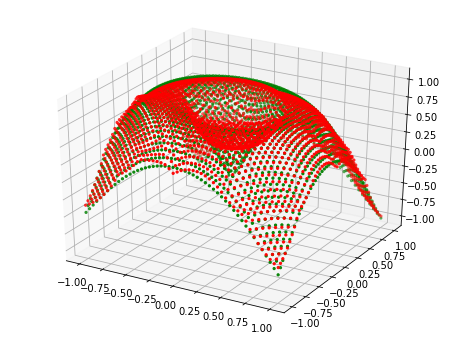

In [54]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

EPOCHS = 4000
for i in range(EPOCHS):
    yout = net(xx)
    error = criterion(yout, yy)
    
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(x1, x2, y, c='g', marker='.')
        ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

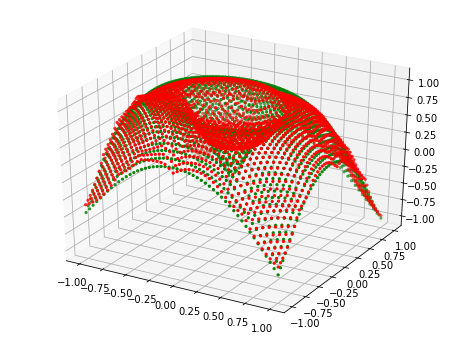

In [55]:
%matplotlib inline

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

ax.clear()
ax.scatter(x1, x2, y, c='g', marker='.')
ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')

plt.show()

### Now embedding using UMAP

In [56]:
embedder = umap.UMAP(n_neighbors=3, n_components=2, min_dist=0.1, spread=1, metric="euclidean")

In [57]:
embedding = embedder.fit_transform(dt.centers.data.cpu().numpy())
embedding

array([[-6.1472836, -5.6578164],
       [-6.948401 , -5.003452 ],
       [-4.9445424, -4.1933384],
       [-5.0390725, -5.6008353],
       [-5.5345526, -4.7572374]], dtype=float32)

In [58]:
emb = embedding - embedding.mean(axis=0, keepdims=True)
emb

array([[-0.42451382, -0.61528015],
       [-1.2256312 ,  0.03908443],
       [ 0.7782273 ,  0.84919786],
       [ 0.6836972 , -0.55829906],
       [ 0.18821716,  0.28529882]], dtype=float32)

(-1.3551041483879087,
 1.493299901485443,
 -1.5088142752647398,
 1.5785798430442808)

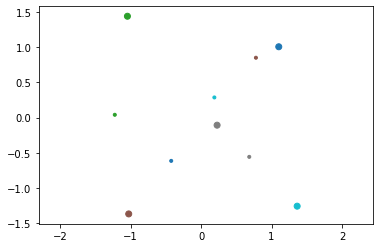

In [59]:
%matplotlib inline
plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.axis('equal')

In [60]:
activs = dt(xx).data.numpy()

In [61]:
i = 40

(-1.1667400658130642,
 1.484330183267593,
 -1.5088142752647398,
 1.5785798430442808)

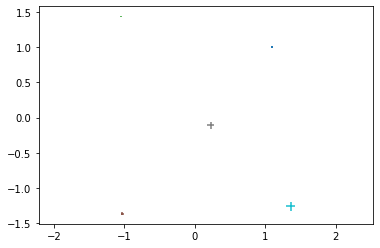

In [62]:
activ = activs[i]
i += 1

# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
# plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')

plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), s=np.maximum(activ*80, 0.01), marker='+',cmap='tab10')
# plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), s=np.maximum(activ*80, 0.01), cmap="tab10")
plt.axis('equal')

In [63]:
### Use the embedding to select Top-K neurons 

In [64]:
# class SpatialAttention(nn.Module):
    
#     def __init__(self, num_inputs, num_outputs, input_embedding, num_neighbour):
#         super().__init__()
#         self.num_inputs = num_inputs
#         self.num_outputs = num_outputs
#         self.num_neighbour = num_neighbour
#         self.input_embedding = torch.Tensor(input_embedding)
        
#         embd_dim = input_embedding.shape[1]
#         self.output_embedding = torch.randn(num_outputs, embd_dim)
        
#     def forward(self, x):
# #         print(self.input_embedding.shape, self.output_embedding.shape)

#         ## take winning neuron for selecting neighbours
#         #### take distance between embeddings
#         edist = torch.cdist(self.input_embedding, self.output_embedding)
# #         print(edist)
#         #### first scale distance to generalized gaussian to select K-nearest neighbours
#         topk_edist, _ = torch.topk(edist, k=self.num_neighbour, dim=1, largest=False, sorted=True)
# #         print(topk_edist)
#         edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
# #         print(edge_dist)

#         A = 10
#         b = 1/edge_dist + 1e-5
# #         print(b.shape)
#         scaler = torch.exp(-(edist**2 * b**2)**A)
#         print(scaler)
        
#         topk_edist1, _ = torch.topk(edist, k=self.num_neighbour, dim=0, largest=False, sorted=True)
# #         print(topk_edist1)
# #         print(topk_edist1.shape)
#         edge_dist1 = topk_edist1[-1:]
# #         print(edge_dist1)
#         b1 = 1/edge_dist1 + 1e-5
# #         print(b.shape)
#         scaler1 = torch.exp(-(edist**2 * b1**2)**A)
#         print(scaler1)
        
#         S = torch.sqrt(scaler*scaler1)
        
#         pass

In [65]:
class SpatialAttention(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, input_embedding, num_neighbour):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_neighbour = num_neighbour
        self.input_embedding = torch.Tensor(input_embedding)
        
        embd_dim = input_embedding.shape[1]
        self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim))
        self.W = None
        
        lin = nn.Linear(num_inputs, num_outputs)
        self.weights = nn.Parameter(lin.weight.data.t())
        self.bias = nn.Parameter(lin.bias.data)
        
    def forward(self, x):
#         print(self.input_embedding.shape, self.output_embedding.shape)

        ## take winning neuron for selecting neighbours
        self.weights.data = torch.clamp(self.weights.data, -2, 2)

#         winner = x.argmax(dim=1)
#         print(winner.shape)
#         print(x.shape)
        #### take distance between embeddings
        edist = torch.cdist(self.input_embedding, self.output_embedding)
#         print(edist)
        self.W = torch.softmax(-2*edist, dim=0)
#         print(W)
#         print(W.sum(dim=0, keepdims=True))
        
        ## use this as weight for transformation
#         y = torch.matmul(x, self.W)

        W = self.W*self.weights
        y = torch.matmul(x, W) + self.bias

        return y

In [66]:
sa = SpatialAttention(5, 16, emb, num_neighbour=3)

In [67]:
sa(dt(xx))

tensor([[-0.2760, -0.3555, -0.3035,  ...,  0.0072,  0.3462, -0.0054],
        [-0.2757, -0.3555, -0.3033,  ...,  0.0073,  0.3465, -0.0053],
        [-0.2754, -0.3555, -0.3031,  ...,  0.0073,  0.3467, -0.0053],
        ...,
        [-0.1225, -0.2326, -0.2842,  ..., -0.0238,  0.3157, -0.2840],
        [-0.1229, -0.2326, -0.2842,  ..., -0.0238,  0.3157, -0.2842],
        [-0.1233, -0.2325, -0.2842,  ..., -0.0237,  0.3157, -0.2843]],
       grad_fn=<AddBackward0>)

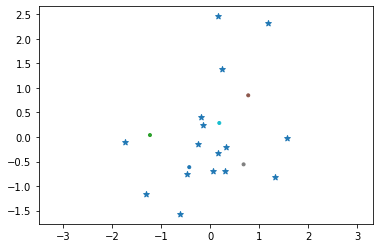

In [68]:
%matplotlib inline
# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sa.output_embedding.data.t(), marker='*')
plt.axis('equal')
plt.show()

### Forward propagate using the Spatial Attention

In [69]:
sanet = nn.Sequential(
        sa,
        nn.LeakyReLU(0.1),
        nn.Linear(16, 1)
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sanet.parameters(), lr=0.01)

Step: 0, error: 0.538243
Step: 100, error: 0.039708
Step: 200, error: 0.030137
Step: 300, error: 0.025670
Step: 400, error: 0.017396
Step: 500, error: 0.015633
Step: 600, error: 0.014663
Step: 700, error: 0.014023
Step: 800, error: 0.013547
Step: 900, error: 0.013118
Step: 1000, error: 0.012738
Step: 1100, error: 0.012379
Step: 1200, error: 0.011795
Step: 1300, error: 0.010925
Step: 1400, error: 0.010299
Step: 1500, error: 0.009719
Step: 1600, error: 0.009004
Step: 1700, error: 0.008655
Step: 1800, error: 0.008373
Step: 1900, error: 0.008131
Step: 2000, error: 0.008005
Step: 2100, error: 0.007689
Step: 2200, error: 0.007475
Step: 2300, error: 0.007311
Step: 2400, error: 0.007195
Step: 2500, error: 0.007070
Step: 2600, error: 0.006959
Step: 2700, error: 0.006879
Step: 2800, error: 0.006786
Step: 2900, error: 0.006701
Step: 3000, error: 0.007076
Step: 3100, error: 0.006555
Step: 3200, error: 0.006481
Step: 3300, error: 0.006407
Step: 3400, error: 0.006354
Step: 3500, error: 0.006295
Step

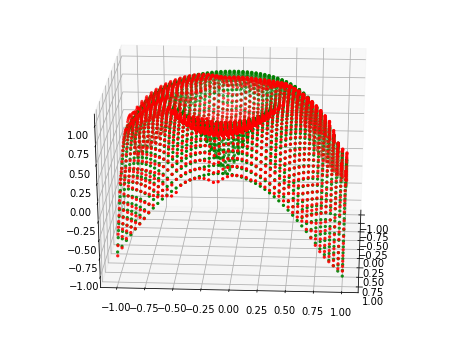

In [70]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

EPOCHS = 4000
for i in range(EPOCHS):
    yout = sanet(dt(xx))

    error = criterion(yout, yy)
    
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(x1, x2, y, c='g', marker='.')
        ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [71]:
sa.W

tensor([[0.6974, 0.1650, 0.1260, 0.0180, 0.2818, 0.2938, 0.1045, 0.0904, 0.0925,
         0.1186, 0.0907, 0.1776, 0.0995, 0.0497, 0.0751, 0.2387],
        [0.1130, 0.0222, 0.0415, 0.0101, 0.0610, 0.1580, 0.8132, 0.0140, 0.3935,
         0.2588, 0.0143, 0.7444, 0.3267, 0.0161, 0.0376, 0.1317],
        [0.0161, 0.0397, 0.1274, 0.7637, 0.0690, 0.0719, 0.0142, 0.0528, 0.2090,
         0.1832, 0.0469, 0.0103, 0.2145, 0.4108, 0.1298, 0.0854],
        [0.0939, 0.6677, 0.2104, 0.0560, 0.2895, 0.1146, 0.0150, 0.7363, 0.0384,
         0.0569, 0.7430, 0.0204, 0.0453, 0.2459, 0.0938, 0.1165],
        [0.0797, 0.1054, 0.4946, 0.1521, 0.2987, 0.3618, 0.0531, 0.1065, 0.2666,
         0.3826, 0.1051, 0.0472, 0.3139, 0.2776, 0.6637, 0.4277]],
       grad_fn=<SoftmaxBackward>)

In [72]:
sanet[0](dt(xx))[0]

tensor([-7.6081e-02,  4.8703e-02, -1.2387e-01,  1.8965e+00,  6.1949e-03,
         1.3638e-01,  4.2085e-01,  2.3454e-01,  1.8950e-01,  3.4524e-01,
         1.7806e-01,  2.0407e-02,  3.9379e-01,  7.8860e-01,  2.7338e-01,
         1.1402e-03], grad_fn=<SelectBackward>)

In [73]:
line_collection = []
weight_collection = []

saW = sa.W*sa.weights

for i, inp in enumerate(sa.input_embedding):
    p0 = tuple(inp.tolist())
    for j, out in enumerate(sa.output_embedding):
        p1 = tuple(out.tolist())
        
        line_collection.append([p0,p1])
#         weight_collection.append(float(sa.W[i,j]))
        weight_collection.append(float(saW[i,j]))
#         break
        
line_collection, weight_collection = np.array(line_collection), np.array(weight_collection)

In [74]:
line_collection

array([[[-0.42451382, -0.61528015],
        [-0.49871469, -0.8067804 ]],

       [[-0.42451382, -0.61528015],
        [ 0.65140742, -1.00054061]],

       [[-0.42451382, -0.61528015],
        [ 0.29064721,  0.02711703]],

       [[-0.42451382, -0.61528015],
        [ 0.98349714,  0.94510186]],

       [[-0.42451382, -0.61528015],
        [ 0.12288523, -0.30912298]],

       [[-0.42451382, -0.61528015],
        [-0.27359644,  0.00898928]],

       [[-0.42451382, -0.61528015],
        [-1.66355252,  0.25443858]],

       [[-0.42451382, -0.61528015],
        [ 0.88790154, -0.7330488 ]],

       [[-0.42451382, -0.61528015],
        [-1.04200125,  1.73872435]],

       [[-0.42451382, -0.61528015],
        [-0.50426757,  0.88287205]],

       [[-0.42451382, -0.61528015],
        [ 0.76449317, -0.67131442]],

       [[-0.42451382, -0.61528015],
        [-1.61106682, -0.29788077]],

       [[-0.42451382, -0.61528015],
        [-0.74406415,  1.34322476]],

       [[-0.42451382, -0.61528015],
  

In [75]:
weight_collection.min(), weight_collection.max()

(-1.4851585626602173, 1.5938012599945068)

In [76]:
from matplotlib import collections
import matplotlib as mpl

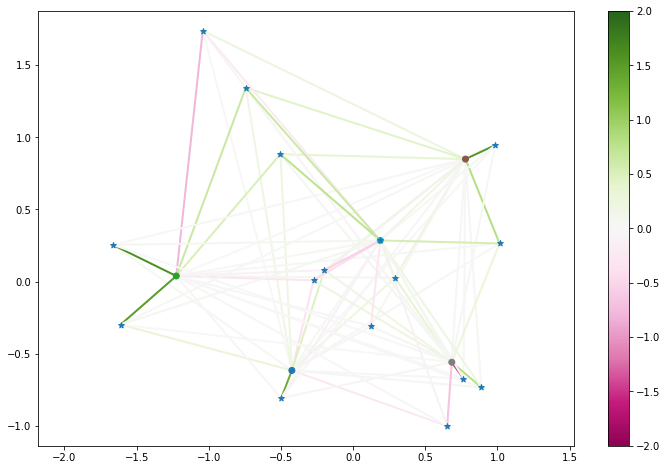

In [78]:
## plot attention weights
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# lc = collections.LineCollection(line_collection, linewidths=weight_collection*5, zorder=-2)
lc = collections.LineCollection(line_collection, 
                                array=weight_collection, linewidths= 2, #weight_collection*2, 
                                norm=mpl.colors.Normalize(vmin=-2, vmax=2),
                                cmap="PiYG", zorder=-2, )

# lc.set_array(weight_collection)
ax.add_collection(lc)
axcb = fig.colorbar(lc)

# ax.autoscale()
# ax.margins(0.1)

plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='o')
plt.scatter(*sa.output_embedding.data.t(), marker='*')

plt.axis('equal')
plt.show()